In [1]:
#include("defArc.jl")

type Arc
    initNode::Int 
    termNode::Int 
    capacity::Float64
    freeflowtime::Float64
    flow::Float64
end

Arc(initNode::Int, termNode::Int, capacity::Float64, freeflowtime::Float64) = 
    Arc(initNode, termNode, capacity, freeflowtime, 0.)

Arc (constructor with 3 methods)

In [2]:
#include("fitTraffic.jl")

## Solve an inverse tarffic problem over polynomials 
## of degree at most d
## optionally use a regularizer from the poly kernel

using JuMP
using Gurobi
using Graphs
using Roots


polyEval(coeffs, pt) = sum([coeffs[i] * pt^(i-1) for i = 1:length(coeffs)])  

polyEval(coeffs::Array{Float64, 1}, pt) = sum([coeffs[i] * pt^(i-1) for i = 1:length(coeffs)]) 

bpacost(flow::Float64, capacity::Float64, freeflowtime::Float64) = freeflowtime*(1 + .15 * (flow/capacity)^4)
bpacost(flow::Float64, arc) = bpacost(flow, arc.capacity, arc.freeflowtime)
bpacost(arc::Arc) = bpacost(arc.flow, arc)

bpacost (generic function with 3 methods)

In [3]:
function setUpFitting(deg::Int, c::Float64)

	m = Model(solver=GurobiSolver(OutputFlag=false))
    
	@defVar(m, coeffs[1:deg+1])
	@defVar(m, Calphas[1:deg+1])

	#build the graham matrix; cf. Ref. [21] (Regularization Networks and Support Vector Machines), page 47
	samples = linspace(0, 1, deg + 1)
	k(x,y) = (c + x*y)^deg
	K = [ k(x,y) for x = samples, y=samples]
	K = convert(Array{Float64, 2}, K)
	#assert(rank(K) == deg+1)
    
	C = chol(K + 1e-6* eye(deg+1))
	for i=1:deg + 1
		@addConstraint(m, polyEval(coeffs, samples[i]) == sum{C[j, i] * Calphas[j], j=1:deg+1})
	end
    
	@defVar(m, reg_term >= 0)
	reg_term_ = QuadExpr(Calphas[:], Calphas[:], ones(deg+1), AffExpr())
    
	@addConstraint(m, reg_term >= reg_term_)
    
	return m, coeffs, reg_term

end

setUpFitting (generic function with 1 method)

In [4]:
function fixCoeffs(m, fcoeffs, coeffs)
	for (fc, c) in zip(fcoeffs, coeffs[:])
		@addConstraint(m, fc == c)
	end
end

fixCoeffs (generic function with 1 method)

In [5]:
function addResid(m, coeffs, ys, demands, arcs, scaling)
	@defVar(m, resid)
	@defVar(m, dual_cost)
	@defVar(m, primal_cost)

	@addConstraint(m, dual_cost == sum{demands[(s,t)] * (ys[(s,t), t] - ys[(s,t), s]), (s,t)=keys(demands)})  
	@addConstraint(m, primal_cost == sum{a.flow * a.freeflowtime * polyEval(coeffs, a.flow/a.capacity), a=values(arcs)})

	@addConstraint(m, resid >= (dual_cost - primal_cost) / scaling )
	@addConstraint(m, resid >= (primal_cost - dual_cost) / scaling )
	return resid
end

addResid (generic function with 1 method)

In [6]:
function addIncreasingCnsts(m, coeffs, arcs; TOL=0.)
	sorted_flows = sort([a.flow / a.capacity for a in values(arcs)])
	@addConstraint(m, polyEval(coeffs, 0) <= polyEval(coeffs, sorted_flows[1]))
	for i = 2:length(sorted_flows)
		@addConstraint(m, polyEval(coeffs, sorted_flows[i-1]) <= polyEval(coeffs, sorted_flows[i]) + TOL)
	end
end

addIncreasingCnsts (generic function with 1 method)

In [7]:
#equates the total cost of the network to the true total cost
function normalize(m, coeffs, tot_true_cost::Float64, arcs)
	@addConstraint(m, 
		sum{a.freeflowtime * a.flow * polyEval(coeffs, a.flow / a.capacity), a=values(arcs)} == tot_true_cost)
end

function normalize(m, coeffs, scaled_flow::Float64, cost::Float64)
	@addConstraint(m, polyEval(coeffs, scaled_flow) == cost)
end

function normalize(m, coeffs, scaled_flows::Array{Float64, 1}, avgCost::Float64)
    @addConstraint(m, sum{polyEval(coeffs, f), f=scaled_flows} == avgCost * length(scaled_flows))
end

normalize (generic function with 3 methods)

In [8]:
function addNetworkCnsts(m, coeffs, demands, arcs, numNodes)
	@defVar(m, ys[keys(demands), 1:numNodes])
	for k = keys(arcs)
		a = arcs[k]
		rhs = a.freeflowtime * polyEval(coeffs, a.flow/a.capacity)
		for od in keys(demands)
			@addConstraint(m, ys[od, k[2]] - ys[od, k[1]] <= rhs)
		end
	end
	return ys
end

addNetworkCnsts (generic function with 1 method)

In [9]:
############
#Read in demand data
file = open("../temp_files/OD_demand_matrix_Oct_weekday_AM.txt")
demands = Dict{(Int64,Int64), Float64}()
n = 8  # number of nodes
for i in [1:n]
    demands[(i,i)] = 0.0
end
for line in eachline(file)
    OD_demand = split(line, ",")
    key, value = (int(OD_demand[1]),int(OD_demand[2])), float(split(OD_demand[3], "\n")[1])
    demands[key] = value
end
close(file)

In [10]:
demands

Dict{(Int64,Int64),Float64} with 64 entries:
  (3,6) => 0.010607
  (4,4) => 0.0
  (3,1) => 1780.020674
  (4,5) => 0.030613
  (2,4) => 1327.684628
  (6,5) => 988.297392
  (8,4) => 1239.23765
  (1,2) => 0.0
  (5,1) => 0.010808
  (3,4) => 0.034468
  (8,2) => 0.011377
  (2,3) => 0.0
  (2,6) => 0.0
  (5,4) => 1261.035528
  (2,1) => 1.0e-5
  (2,5) => 0.0
  (8,5) => 0.004602
  (1,4) => 0.0
  (2,8) => 0.0
  (5,8) => 0.058617
  (4,8) => 1242.134799
  (7,8) => 910.045303
  (1,1) => 0.0
  (7,7) => 0.0
  (5,7) => 909.92081
  ⋮     => ⋮

In [11]:
using JSON

link_day_minute_Oct_dict = readall("../temp_files/link_day_minute_Oct_dict_JSON.json");
link_day_minute_Oct_dict = replace(link_day_minute_Oct_dict, "NaN", 0);

link_day_minute_Oct_dict = JSON.parse(link_day_minute_Oct_dict);

In [12]:
# week_day_Oct_list = [1, 2, 3, 4, 5, 8, 9, 10, 11, 12, 15, 16, 17, 18, 19, 22, 23, 24, 25, 26, 29, 30, 31]

# training set 1
week_day_Oct_list_1 = [1, 2, 3, 4, 5, 8, 9, 10, 11, 12, 15, 16, 17, 18, 19]

# training set 2
week_day_Oct_list_2 = [1, 2, 3, 4, 5, 8, 9, 22, 23, 24, 25, 26, 29, 30, 31]

# training set 3
week_day_Oct_list_3 = [11, 12, 15, 16, 17, 18, 19, 22, 23, 24, 25, 26, 29, 30, 31]


arcs_1 = Dict{(Int, Int), Arc}[]
for j in week_day_Oct_list_1
    arcs_1_ = Dict{(Int, Int), Arc}()
    for i = 0:23
        key = "link_$(i)_$(j)"
        initNode = link_day_minute_Oct_dict[key]["init_node"]
        termNode = link_day_minute_Oct_dict[key]["term_node"]
        capacity = link_day_minute_Oct_dict[key]["AM_capac"]
        freeflowtime = link_day_minute_Oct_dict[key]["free_flow_time"]
        flow = link_day_minute_Oct_dict[key]["AM_flow"]
        arcs_1_[(initNode, termNode)] = Arc(initNode, termNode, capacity, freeflowtime, flow)
    end
    push!(arcs_1, arcs_1_)
end

arcs_2 = Dict{(Int, Int), Arc}[]
for j in week_day_Oct_list_2
    arcs_2_ = Dict{(Int, Int), Arc}()
    for i = 0:23
        key = "link_$(i)_$(j)"
        initNode = link_day_minute_Oct_dict[key]["init_node"]
        termNode = link_day_minute_Oct_dict[key]["term_node"]
        capacity = link_day_minute_Oct_dict[key]["AM_capac"]
        freeflowtime = link_day_minute_Oct_dict[key]["free_flow_time"]
        flow = link_day_minute_Oct_dict[key]["AM_flow"]
        arcs_2_[(initNode, termNode)] = Arc(initNode, termNode, capacity, freeflowtime, flow)
    end
    push!(arcs_2, arcs_2_)
end

arcs_3 = Dict{(Int, Int), Arc}[]
for j in week_day_Oct_list_3
    arcs_3_ = Dict{(Int, Int), Arc}()
    for i = 0:23
        key = "link_$(i)_$(j)"
        initNode = link_day_minute_Oct_dict[key]["init_node"]
        termNode = link_day_minute_Oct_dict[key]["term_node"]
        capacity = link_day_minute_Oct_dict[key]["AM_capac"]
        freeflowtime = link_day_minute_Oct_dict[key]["free_flow_time"]
        flow = link_day_minute_Oct_dict[key]["AM_flow"]
        arcs_3_[(initNode, termNode)] = Arc(initNode, termNode, capacity, freeflowtime, flow)
    end
    push!(arcs_3, arcs_3_)
end

In [13]:
##########
# Set up demand data and flow data
##########
numData = length(arcs_1); 
sigma = .0

flow_data_1 = Array(Float64, length(arcs_1[1]), numData)
flow_data_2 = Array(Float64, length(arcs_2[1]), numData)
flow_data_3 = Array(Float64, length(arcs_3[1]), numData)

demand_data = Dict{(Int, Int), Array{Float64, 1}}()

numNodes = maximum(map(pair->pair[1], keys(demands)))
g = simple_inclist(numNodes, is_directed=true)
vArcs = Arc[]
for arc in values(arcs_1[1])
    add_edge!(g, arc.initNode, arc.termNode) 
    push!(vArcs, arc)
end


for iRun = 1:numData
    for odpair in keys(demands)
        if ! haskey(demand_data, odpair)
            demand_data[odpair] = [demands[odpair], ]
        else
            push!(demand_data[odpair], demands[odpair])
        end
    end

    #flow_data[:, iRun] = [a.flow::Float64 for a in vArcs]
    flow_data_1[:, iRun] = [a.flow::Float64 for a in values(arcs_1[iRun])]
    flow_data_2[:, iRun] = [a.flow::Float64 for a in values(arcs_2[iRun])]
    flow_data_3[:, iRun] = [a.flow::Float64 for a in values(arcs_3[iRun])]
end

In [14]:
demand_data

Dict{(Int64,Int64),Array{Float64,1}} with 64 entries:
  (3,6) => [0.010607,0.010607,0.010607,0.010607,0.010607,0.010607,0.010607,0.01…
  (4,4) => [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
  (3,1) => [1780.020674,1780.020674,1780.020674,1780.020674,1780.020674,1780.02…
  (4,5) => [0.030613,0.030613,0.030613,0.030613,0.030613,0.030613,0.030613,0.03…
  (2,4) => [1327.684628,1327.684628,1327.684628,1327.684628,1327.684628,1327.68…
  (6,5) => [988.297392,988.297392,988.297392,988.297392,988.297392,988.297392,9…
  (8,4) => [1239.23765,1239.23765,1239.23765,1239.23765,1239.23765,1239.23765,1…
  (1,2) => [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
  (5,1) => [0.010808,0.010808,0.010808,0.010808,0.010808,0.010808,0.010808,0.01…
  (3,4) => [0.034468,0.034468,0.034468,0.034468,0.034468,0.034468,0.034468,0.03…
  (8,2) => [0.011377,0.011377,0.011377,0.011377,0.011377,0.011377,0.011377,0.01…
  (2,3) => [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [15]:
flow_data_3

24x15 Array{Float64,2}:
 1446.72   1365.3   1463.18  1376.13   …  1443.48  1403.69  1372.29 
 1511.9    1543.9   1543.27  1563.71      1579.83  1554.25  1540.22 
  809.264  1219.99  1215.68  1161.92      1324.17  1313.69  1248.5  
 1313.39   1306.13  1322.89  1336.42      1383.89  1385.06  1320.68 
 1239.04   1194.63  1241.64  1222.66      1213.04  1188.6   1249.97 
  946.026  1053.09   868.09   764.7    …  1281.84  1285.49   915.29 
 1245.26   1479.94  1073.65  1385.23      1526.35  1469.81  1369.62 
 1522.67   1502.9   1508.73  1490.09      1559.96  1507.01  1494.32 
 1146.38   1330.48  1232.85  1198.32      1248.63  1204.97  1246.43 
 1318.97   1253.22  1327.59  1304.21      1261.55  1279.5   1337.28 
 1583.78   1582.91  1576.66  1591.37   …  1601.61  1639.34  1591.86 
 1252.69   1228.6   1235.06  1248.94      1273.09  1271.38  1245.62 
 1789.07   1566.75  1790.16   931.444     1624.27  1592.96  1743.52 
 1415.97   1526.79  1504.55  1518.9       1487.42  1512.4   1509.57 
 1279.3   

In [16]:
##########
#Fitting Funcs
##########

function train(indices, lam::Float64, deg::Int, c::Float64, demand_data, flow_data, arcs; fcoeffs=nothing)
    numNodes = maximum(map(pair->pair[1], keys(arcs)))
    m, coeffs, reg_term = setUpFitting(deg, c)
    
    addIncreasingCnsts(m, coeffs, arcs, TOL=1e-8)  #uses the original obs flows

    avgCost = mean( [bpacost(a.flow, a.capacity, 1.0) for a in values(arcs)] )
    normalize(m, coeffs, [a.flow / a.capacity for a in values(arcs)], avgCost)


    resids = Variable[]
    
    for i = indices
        #copy the flow data over to the arcs, demand data to demands (slow)
        for (ix, a) in enumerate(vArcs)
            a.flow = flow_data[ix, i]
        end
        for odpair in keys(demands)
            demands[odpair] = demand_data[odpair][i]
        end
    
        #Dual Feasibility
        ys = addNetworkCnsts(m, coeffs, demands, arcs, numNodes)
        
        #add the residual for this data point
        push!(resids, addResid(m, coeffs, ys, demands, arcs, 1e6))
    end

    if fcoeffs != nothing
        fixCoeffs(m, fcoeffs, coeffs)
    end
    @setObjective(m, Min, sum{resids[i], i = 1:length(resids)} + lam*reg_term)
    solve(m)
    #println(getObjectiveValue(m) - lam * getValue(reg_term) )
    return [getValue(coeffs[i]) for i =1:length(coeffs)]
end

train (generic function with 1 method)

In [17]:
#include("trafficCval.jl")

coeffs_dict_Oct_AM = Dict{(Int64,Float64,Float64,Int64),Array{Float64,1}}()

deg_grid = [4:8]
c_grid = .5:.5:3.
lamb_grid = [10. .^(-3:4)]

for deg in deg_grid
    for c in c_grid
        for lam in lamb_grid
            coeffs_dict_Oct_AM[(deg, c, lam, 1)] = train(1:numData, lam, deg, c, demand_data, flow_data_1, arcs_1[1])
            coeffs_dict_Oct_AM[(deg, c, lam, 2)] = train(1:numData, lam, deg, c, demand_data, flow_data_2, arcs_2[1])
            coeffs_dict_Oct_AM[(deg, c, lam, 3)] = train(1:numData, lam, deg, c, demand_data, flow_data_3, arcs_3[1])
        end
    end
end

In [18]:
outfile = open("../temp_files/coeffs_dict_Oct_AM.json", "w")

JSON.print(outfile, coeffs_dict_Oct_AM)

close(outfile)

In [19]:
coeffs_dict_Oct_AM_ = readall("../temp_files/coeffs_dict_Oct_AM.json")
coeffs_dict_Oct_AM_ = JSON.parse(coeffs_dict_Oct_AM_)

Dict{String,Any} with 720 entries:
  "(7,2.5,10000.0,3)" => {0.21534262255798067,0.47805425396829,0.46248896154285,…
  "(5,0.5,100.0,3)"   => {0.01646727503013008,0.13061387330102595,0.421399508757…
  "(6,1.5,10.0,3)"    => {0.12979037428035564,0.40197803073101224,0.529345270454…
  "(6,2.0,0.1,2)"     => {0.3524931659798866,0.6244156884950987,0.34807640353329…
  "(4,0.5,1000.0,1)"  => {0.034580888541556526,0.22502161284441557,0.55852797645…
  "(6,2.0,0.01,1)"    => {0.7519579406231279,0.6137244023084243,-0.1230666374590…
  "(8,1.5,0.01,1)"    => {0.4480536676426979,0.9104497038067133,0.36513339196745…
  "(5,1.5,1.0,1)"     => {0.18263313320199953,0.4655561134647013,0.4864699556078…
  "(8,2.5,0.001,2)"   => {-1.9846398151697482,6.576663234740726,-0.8994763147593…
  "(4,2.0,0.1,1)"     => {0.45423313917319047,0.5407236635722683,0.2299470289076…
  "(5,1.0,1000.0,2)"  => {0.07763333133624833,0.3203029237943882,0.5336872605643…
  "(4,2.0,0.1,2)"     => {0.4108461050793068,0.540402433234751,

In [20]:
coeffs_dict_Oct_AM_["(8,0.5,10000.0,1)"]

9-element Array{Any,1}:
 0.000988791
 0.0128626  
 0.0746394  
 0.249069   
 0.531464   
 0.714627   
 0.624806   
 0.299694   
 0.0667402  

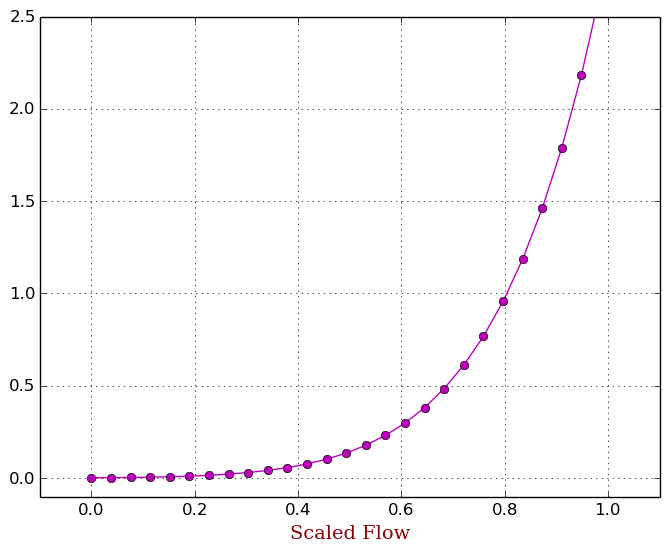

In [22]:
using PyPlot

fcoeffs = coeffs_dict_Oct_AM_["(8,0.5,10.0,3)"]


xs = linspace(0, 1.1, 30)
ys = map(x->polyEval(fcoeffs, x), xs)

plot(xs, ys, "o-m", label="Oct_AM")

#legend(loc="upper left",fancybox="true") 

grid("on")
xlim(-0.1, 1.1);
ylim(-0.1, 2.5);

font1 = ["family"=>"serif",
    "color"=>"darkred",
    "weight"=>"normal",
    "size"=>14]
xlabel("Scaled Flow", fontdict=font1)

savefig("../temp_files/fitting_Oct_AM.pdf")